# `TauModel` Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the basic features of the `TauModel` model. `TauModel` models the 1612, 1665, 1667, and 1720 MHz hyperfine transitions of OH and predicts their optical depth spectra.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

from amoeba2 import TauModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.2+0.g883013c.dirty
amoeba2 version: 0+untagged.12.ge17a301.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `TauModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"tau_1612", "tau_1665", "tau_1667", and "tau_1720"`.

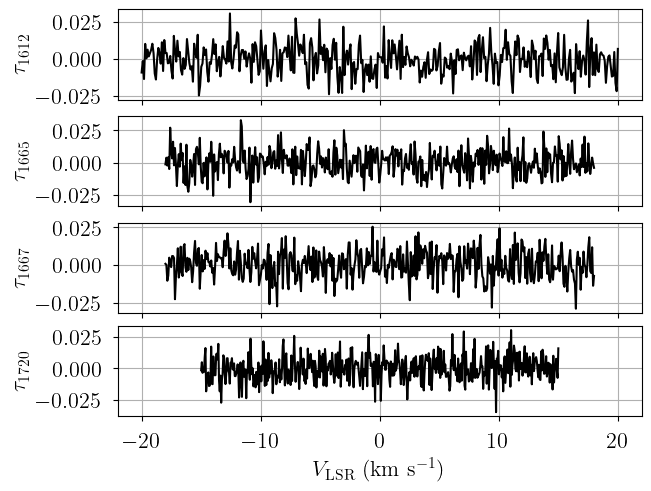

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_tau = {
    "1612": 0.01,
    "1665": 0.01,
    "1667": 0.01,
    "1720": 0.01,
}

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
tau = {label: rms_tau[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

# TauModel expects four observations
dummy_data = {
    f"tau_{label}": SpecData(velo_axis[label], tau[label], rms_tau[label], xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)", ylabel=r"$\tau_{"+f"{label}"+r"}$")
    for label in velo_axis.keys()
}

# Plot dummy data
fig, axes = plt.subplots(4, sharex=True, layout="constrained")
for ax, dummy_datum in zip(axes, dummy_data.values()):
    ax.plot(dummy_datum.spectral, dummy_datum.brightness, "k-")
    ax.set_ylabel(dummy_datum.ylabel)
_ = axes[-1].set_xlabel(dummy_datum.xlabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = TauModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of optical depth rms prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
# excitation temperature sum rule
inv_Tex_free = np.array([[0.2, -0.2, 0.06], [0.06, 0.1, 0.2], [0.06, 0.06, 0.1]])
inv_Tex_1720 = (
    inv_Tex_free[1] * model.mol_data["freq"][1]
    + inv_Tex_free[2] * model.mol_data["freq"][2]
    - inv_Tex_free[0] * model.mol_data["freq"][0]
) / model.mol_data["freq"][3]
inv_Tex = np.concatenate([inv_Tex_free, inv_Tex_1720[None]], axis=0)

sim_params = {
    "log10_N_0_norm": np.array([1.0, 1.5, 0.5]),
    "inv_Tex": inv_Tex,
    "fwhm": np.array([1.2, 1.5, 0.8]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
    "rms_tau": np.array([0.01, 0.008, 0.012, 0.01]),
}
data = {}
for i, label in enumerate(velo_axis.keys()):
    sim_params_label = sim_params.copy()
    sim_params_label[f"baseline_tau_{label}_norm"] = np.array([0.0, -1.0, 2.0])
    tau = model.model[f"tau_{label}"].eval(sim_params_label)
    data[f"tau_{label}"] = SpecData(
        velo_axis[label],
        tau,
        sim_params["rms_tau"][i],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{label}"+r"}$"
    )

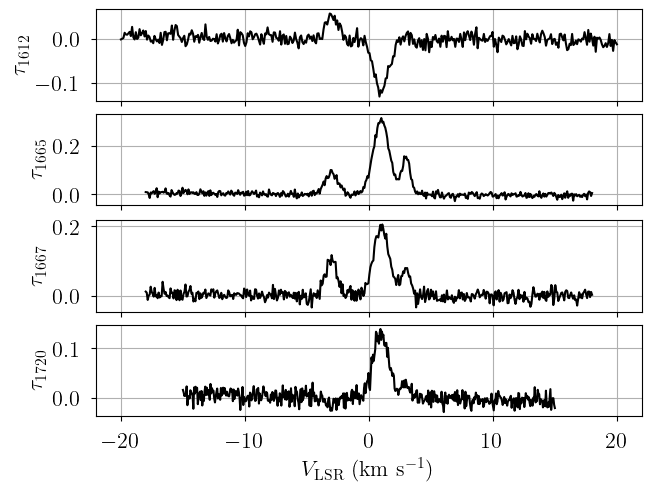

In [5]:
# Plot data
fig, axes = plt.subplots(4, sharex=True, layout="constrained")
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `HFSModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = TauModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [0.0, 1.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.1, # width of optical depth rms prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

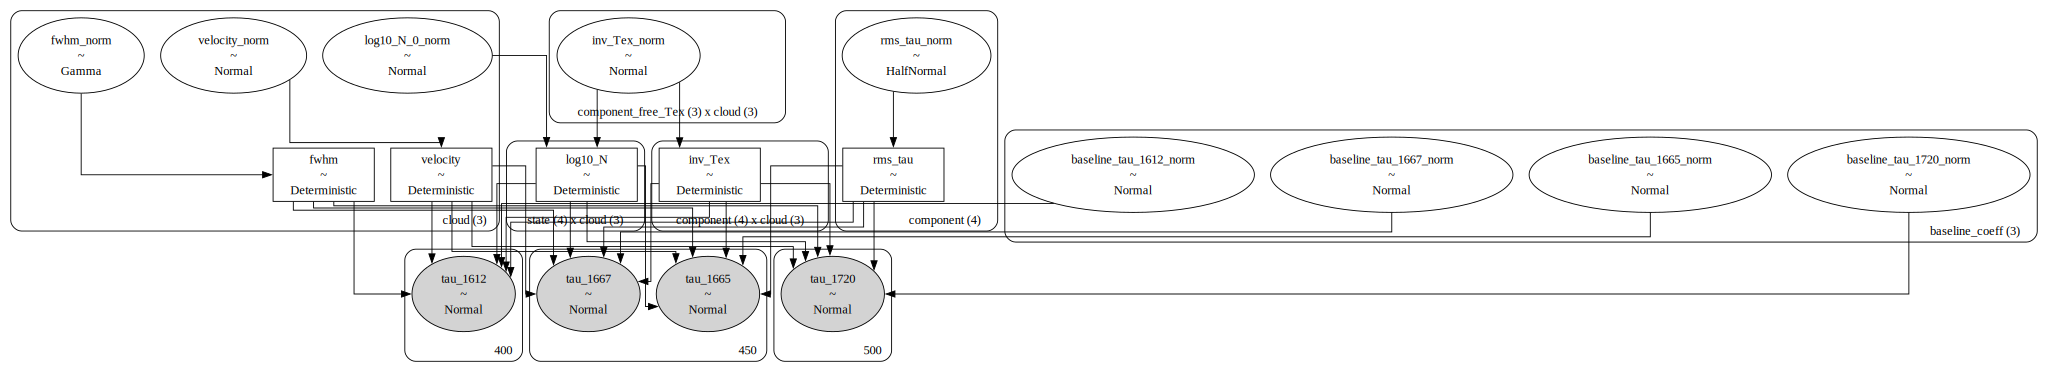

In [7]:
# Plot model graph
model.graph().render('tau_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

baseline_tau_1612_norm ~ Normal(0, <constant>)
baseline_tau_1665_norm ~ Normal(0, <constant>)
baseline_tau_1667_norm ~ Normal(0, <constant>)
baseline_tau_1720_norm ~ Normal(0, <constant>)
        log10_N_0_norm ~ Normal(0, 1)
          inv_Tex_norm ~ Normal(0, 1)
             fwhm_norm ~ Gamma(2, f())
         velocity_norm ~ Normal(0, 1)
          rms_tau_norm ~ HalfNormal(0, 1)
               inv_Tex ~ Deterministic(f(inv_Tex_norm))
               log10_N ~ Deterministic(f(log10_N_0_norm, inv_Tex_norm))
                  fwhm ~ Deterministic(f(fwhm_norm))
              velocity ~ Deterministic(f(velocity_norm))
               rms_tau ~ Deterministic(f(rms_tau_norm))
              tau_1612 ~ Normal(f(baseline_tau_1612_norm, log10_N_0_norm, fwhm_norm, inv_Tex_norm, velocity_norm), f(rms_tau_norm))
              tau_1665 ~ Normal(f(baseline_tau_1665_norm, log10_N_0_norm, fwhm_norm, inv_Tex_norm, velocity_norm), f(rms_tau_norm))
              tau_1667 ~ Normal(f(baseline_tau_1667_norm, l

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, fwhm_norm, inv_Tex_norm, log10_N_0_norm, rms_tau_norm, tau_1612, tau_1665, tau_1667, tau_1720, velocity_norm]


array([[<Axes: xlabel='$V_{\\rm LSR}$ (km s$^{-1}$)', ylabel='$\\tau_{1612}$'>],
       [<Axes: xlabel='$V_{\\rm LSR}$ (km s$^{-1}$)', ylabel='$\\tau_{1665}$'>],
       [<Axes: xlabel='$V_{\\rm LSR}$ (km s$^{-1}$)', ylabel='$\\tau_{1667}$'>],
       [<Axes: xlabel='$V_{\\rm LSR}$ (km s$^{-1}$)', ylabel='$\\tau_{1720}$'>]],
      dtype=object)

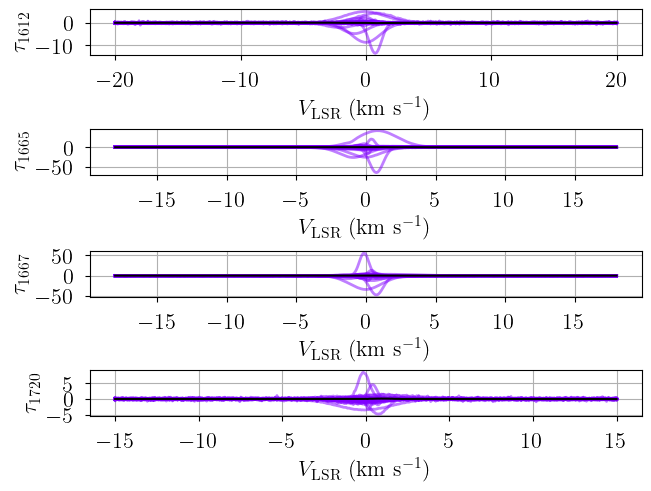

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6400
Interrupted at 6,399 [6%]: Average Loss = -4,515.7


Runtime: 0.34 minutes


In [11]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_tau_1612_norm[0],0.067,0.024,0.019,0.113,0.001,0.001,926.0,948.0,NaN
baseline_tau_1612_norm[1],-0.478,0.085,-0.633,-0.317,0.003,0.002,797.0,873.0,NaN
baseline_tau_1612_norm[2],1.004,0.464,0.120,1.848,0.013,0.010,1190.0,1024.0,NaN
baseline_tau_1665_norm[0],-0.384,0.008,-0.399,-0.369,0.000,0.000,1075.0,1024.0,NaN
baseline_tau_1665_norm[1],-0.203,0.027,-0.254,-0.152,0.001,0.001,864.0,866.0,NaN
baseline_tau_1665_norm[2],0.392,0.153,0.113,0.686,0.005,0.003,1014.0,979.0,NaN
baseline_tau_1667_norm[0],-0.406,0.015,-0.435,-0.377,0.001,0.000,958.0,937.0,NaN
baseline_tau_1667_norm[1],-0.171,0.058,-0.274,-0.069,0.002,0.001,858.0,875.0,NaN
baseline_tau_1667_norm[2],1.186,0.285,0.683,1.725,0.009,0.007,928.0,1059.0,NaN
baseline_tau_1720_norm[0],-0.307,0.021,-0.344,-0.265,0.001,0.000,1035.0,945.0,NaN


Sampling: [tau_1612, tau_1665, tau_1667, tau_1720]


Output()

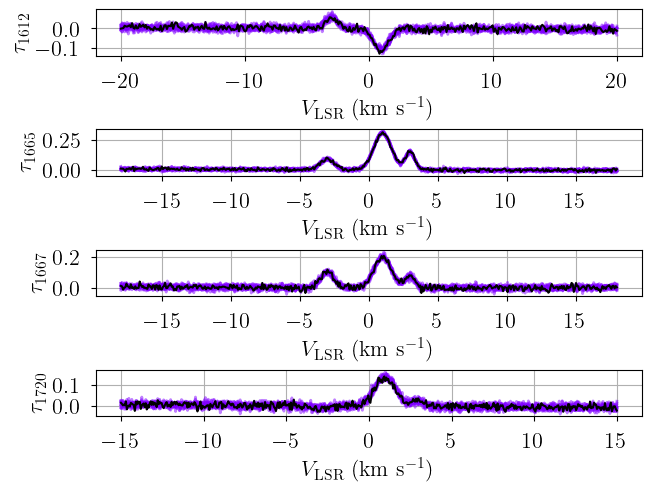

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [30]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 2000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6400
Interrupted at 6,399 [6%]: Average Loss = -4,515.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, log10_N_0_norm, inv_Tex_norm, fwhm_norm, velocity_norm, rms_tau_norm]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 506 seconds.


There were 76 divergences in converged chains.
Runtime: 8.99 minutes


In [31]:
model._cluster_features = ["log10_N_0_norm", "velocity", "fwhm"]
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [33]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)
# inv_Tex_free = np.array([[0.2, -0.2, 0.06], [0.06, 0.1, 0.2], [0.06, 0.06, 0.1]])

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_tau_1612_norm[0],0.083,0.034,0.020,0.147,0.001,0.000,3343.0,2948.0,1.00
baseline_tau_1612_norm[1],-0.467,0.081,-0.621,-0.317,0.001,0.001,5380.0,2678.0,1.00
baseline_tau_1612_norm[2],0.718,0.583,-0.329,1.861,0.010,0.008,3529.0,3099.0,1.00
baseline_tau_1665_norm[0],-0.375,0.013,-0.399,-0.349,0.000,0.000,2920.0,2562.0,1.00
baseline_tau_1665_norm[1],-0.201,0.024,-0.248,-0.157,0.000,0.000,5096.0,2455.0,1.00
baseline_tau_1665_norm[2],0.421,0.235,-0.024,0.853,0.004,0.003,3143.0,2759.0,1.00
baseline_tau_1667_norm[0],-0.413,0.025,-0.461,-0.366,0.000,0.000,3130.0,2942.0,1.00
baseline_tau_1667_norm[1],-0.153,0.050,-0.248,-0.062,0.001,0.001,5079.0,3118.0,1.00
baseline_tau_1667_norm[2],1.246,0.448,0.416,2.090,0.008,0.006,3045.0,2904.0,1.00
baseline_tau_1720_norm[0],-0.290,0.027,-0.340,-0.239,0.001,0.000,2880.0,2436.0,1.00


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [tau_1612, tau_1665, tau_1667, tau_1720]


Output()

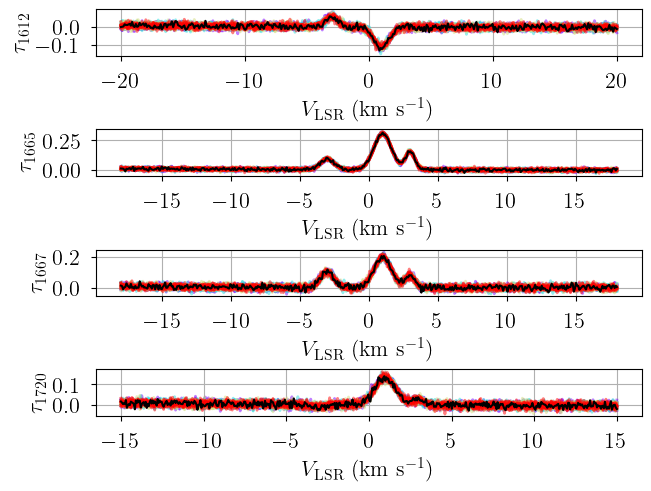

In [34]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

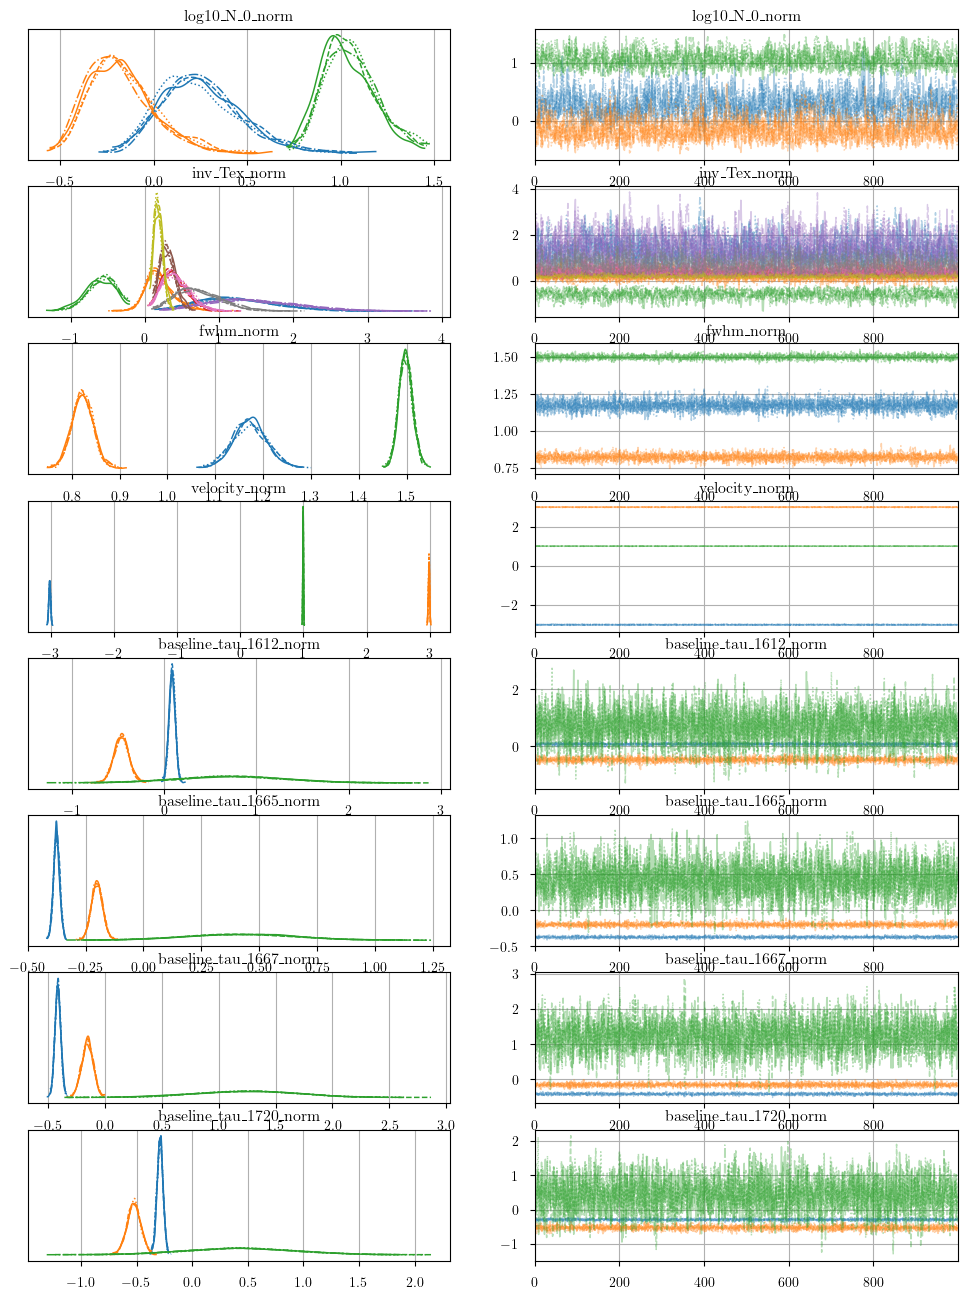

In [35]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

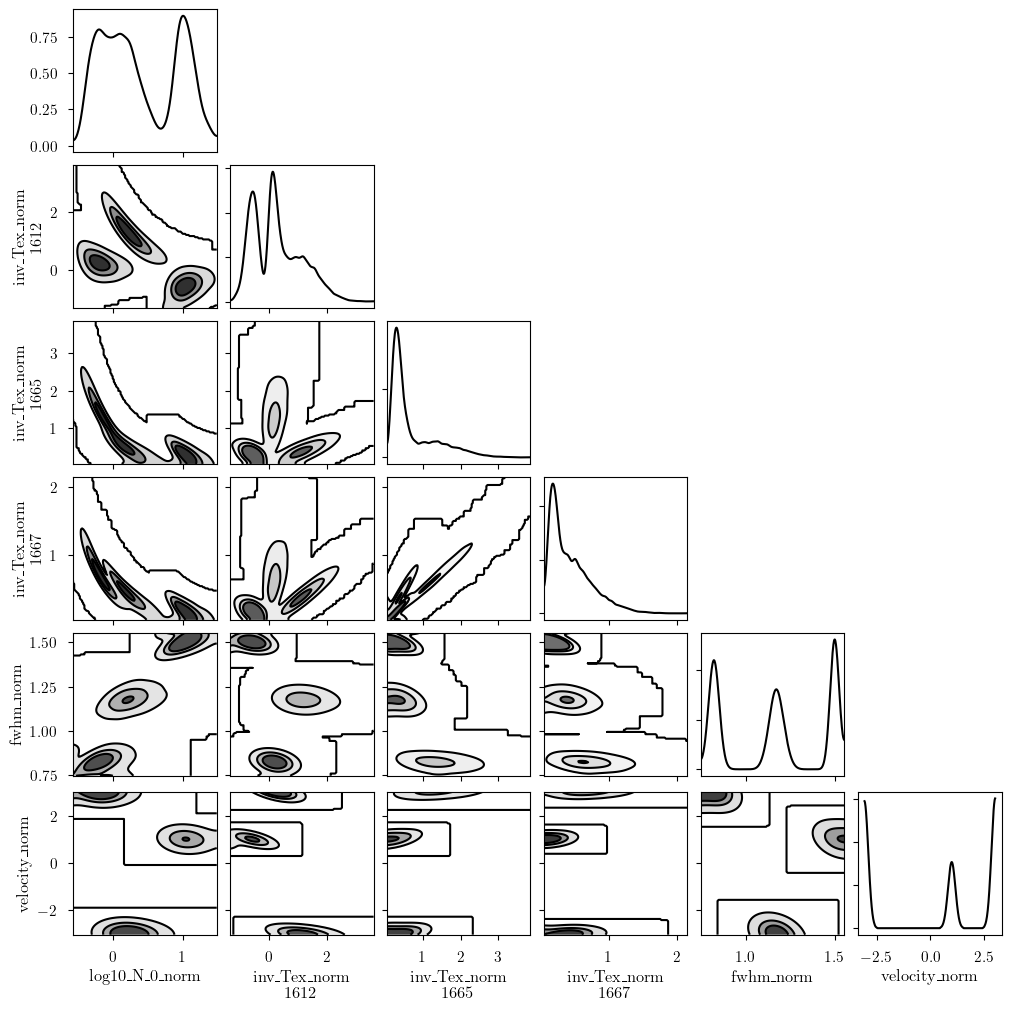

In [36]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud.

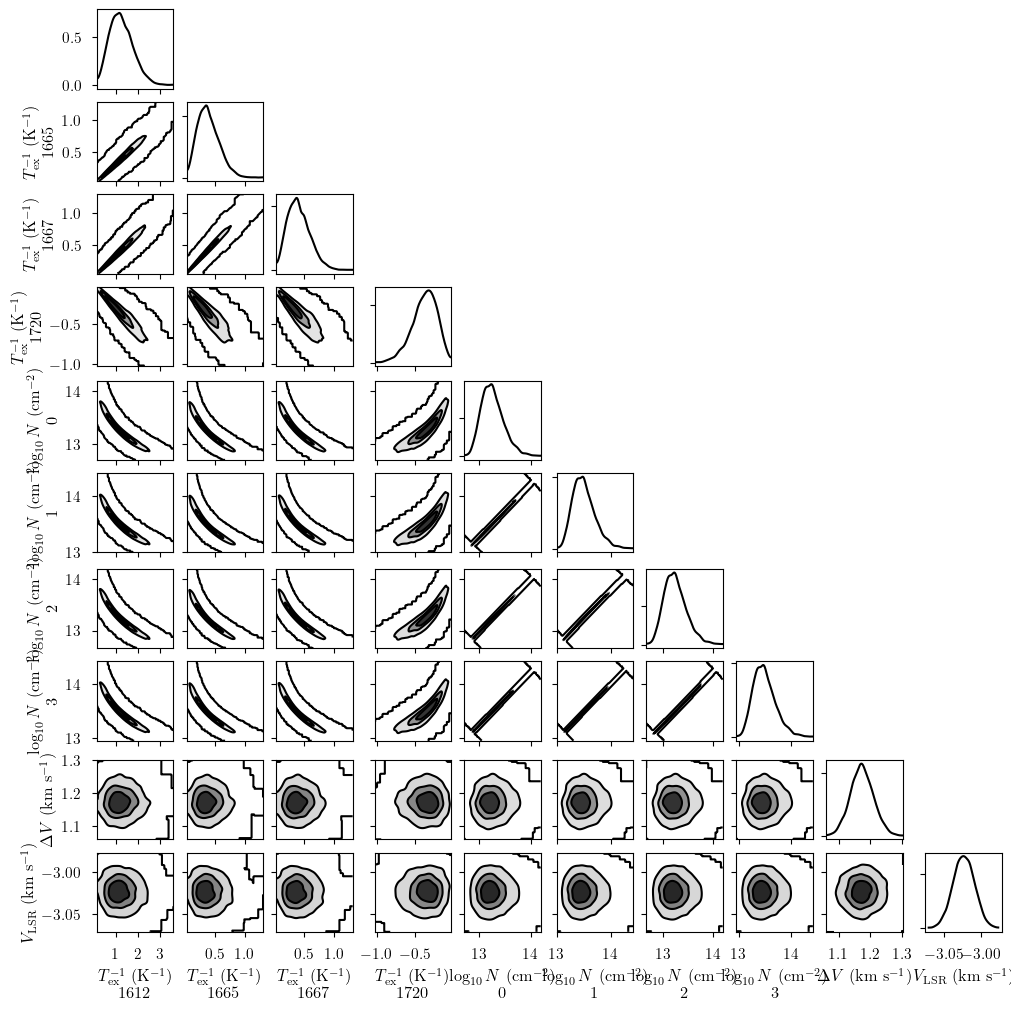

In [38]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [39]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -10910.801644322344


,mean,sd,hdi_16%,hdi_84%
baseline_tau_1612_norm[0],0.083,0.034,0.049,0.116
baseline_tau_1612_norm[1],-0.467,0.081,-0.542,-0.386
baseline_tau_1612_norm[2],0.718,0.583,0.177,1.329
baseline_tau_1665_norm[0],-0.375,0.013,-0.388,-0.362
baseline_tau_1665_norm[1],-0.201,0.024,-0.222,-0.175
baseline_tau_1665_norm[2],0.421,0.235,0.196,0.659
baseline_tau_1667_norm[0],-0.413,0.025,-0.439,-0.389
baseline_tau_1667_norm[1],-0.153,0.050,-0.200,-0.100
baseline_tau_1667_norm[2],1.246,0.448,0.873,1.762
baseline_tau_1720_norm[0],-0.290,0.027,-0.316,-0.262
